In [ ]:
# %pip install -r requirements.txt

# # PyTorch install for CUDA 12.1
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
from torch.utils.data import DataLoader
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import evaluate
import datasets
from datasets import (
    load_dataset,
    load_metric,
    Dataset,
    DatasetDict
)
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

In [2]:
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        count = 0
        for batch in data_loader:
            if None in batch["sentence"]:
                continue  # Überspringen dieses Batches
            count += 1
            print(count, '/', len(data_loader))
            sentences = batch["sentence"]
            labels = batch["label"].to(device) 

            inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
            inputs = {key: val.to(device) for key, val in inputs.items()}

            outputs = model(**inputs)
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.view(-1).tolist())
            true_labels.extend(labels.view(-1).tolist())
    
    return true_labels, predictions

### Setting a device depending on whats available
* ´cuda´ for GPU
* ´cpu´ for CPU
* ´mps´ for Apple silicon

In [3]:
# set random seeds to make sure results are reproducible
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# set device to cuda or mps if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)

cuda


### Split data in train, test and validation

In [4]:
# load the dataset
raw_datasets = load_dataset("csv", data_files="data.csv", split="train")

# change column name lyrics to sentence and playlist_genre to label
raw_datasets = raw_datasets.rename_column("lyrics", "sentence")
raw_datasets = raw_datasets.rename_column("playlist_genre", "label")

# Split the dataset into train, validation, and test sets
train_testvalid = raw_datasets.train_test_split(test_size=0.2, seed=SEED)
test_valid = train_testvalid["test"].train_test_split(test_size=0.5, seed=SEED)

# Assign the resulting datasets to variables
train_dataset = train_testvalid["train"]
valid_dataset = test_valid["train"]
test_dataset = test_valid["test"]

# Now you have train_dataset, valid_dataset, and test_dataset
raw_datasets = {
    "train": train_dataset,
    "validation": valid_dataset,
    "test": test_dataset,
}
raw_datasets = datasets.DatasetDict(raw_datasets)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'sentence'],
        num_rows: 155966
    })
    validation: Dataset({
        features: ['label', 'sentence'],
        num_rows: 19496
    })
    test: Dataset({
        features: ['label', 'sentence'],
        num_rows: 19496
    })
})

### Tokenize the data

In [5]:
from transformers import AutoTokenizer
from datasets import DatasetDict

model_name = "distilbert-base-uncased"

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)


# Function to tokenize a single row
def tokenize_function(row):
    try:
        # Ensure that 'lyrics' is always a string. Replace non-strings with a placeholder.
        lyrics = [
            str(lyric) if isinstance(lyric, str) else "" for lyric in row["sentence"]
        ]
        return tokenizer(lyrics, truncation=True, padding="max_length", max_length=512)
    except Exception as e:
        print(f"Error tokenizing row: {row}")
        print(f"Exception: {e}")
        return None


# Apply tokenization to each subset
tokenized_train = raw_datasets["train"].map(tokenize_function, batched=True)
tokenized_validation = raw_datasets["validation"].map(tokenize_function, batched=True)
tokenized_test = raw_datasets["test"].map(tokenize_function, batched=True)

# Combine back into a DatasetDict
tokenized_datasets = DatasetDict(
    {
        "train": tokenized_train,
        "validation": tokenized_validation,
        "test": tokenized_test,
    }
)

# Check the result
tokenized_datasets

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['label', 'sentence', 'input_ids', 'attention_mask'],
        num_rows: 155966
    })
    validation: Dataset({
        features: ['label', 'sentence', 'input_ids', 'attention_mask'],
        num_rows: 19496
    })
    test: Dataset({
        features: ['label', 'sentence', 'input_ids', 'attention_mask'],
        num_rows: 19496
    })
})

### Get predictions for test data

In [8]:
# Laden des Modells
model = AutoModelForSequenceClassification.from_pretrained("./genre_model").to(device)
test_loader = DataLoader(tokenized_datasets["test"], batch_size=16, shuffle=False)
print(test_loader.dataset)

true_labels, predictions = get_predictions(model, test_loader)

Dataset({
    features: ['label', 'sentence', 'input_ids', 'attention_mask'],
    num_rows: 19496
})
1 / 1219
2 / 1219
3 / 1219
4 / 1219
5 / 1219
6 / 1219
7 / 1219
8 / 1219
9 / 1219
10 / 1219
11 / 1219
12 / 1219
13 / 1219
14 / 1219
15 / 1219
16 / 1219
17 / 1219
18 / 1219
19 / 1219
20 / 1219
21 / 1219
22 / 1219
23 / 1219
24 / 1219
25 / 1219
26 / 1219
27 / 1219
28 / 1219
29 / 1219
30 / 1219
31 / 1219
32 / 1219
33 / 1219
34 / 1219
35 / 1219
36 / 1219
37 / 1219
38 / 1219
39 / 1219
40 / 1219
41 / 1219
42 / 1219
43 / 1219
44 / 1219
45 / 1219
46 / 1219
47 / 1219
48 / 1219
49 / 1219
50 / 1219
51 / 1219
52 / 1219
53 / 1219
54 / 1219
55 / 1219
56 / 1219
57 / 1219
58 / 1219
59 / 1219
60 / 1219
61 / 1219
62 / 1219
63 / 1219
64 / 1219
65 / 1219
66 / 1219
67 / 1219
68 / 1219
69 / 1219
70 / 1219
71 / 1219
72 / 1219
73 / 1219
74 / 1219
75 / 1219
76 / 1219
77 / 1219
78 / 1219
79 / 1219
80 / 1219
81 / 1219
82 / 1219
83 / 1219
84 / 1219
85 / 1219
86 / 1219
87 / 1219
88 / 1219
89 / 1219
90 / 1219
91 / 121

### Confusion matrix

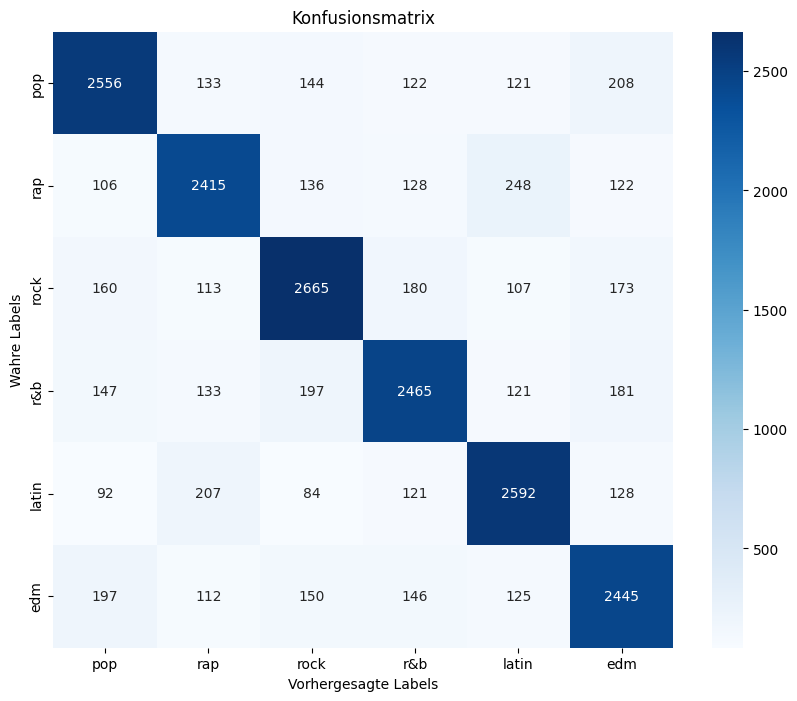

In [10]:
# change label numbers back to genre names
true_labels_converted = ["pop" if label == 0 else "rap" if label == 1 else "rock" if label == 2 else "r&b" if label == 3 else "latin" if label == 4 else "edm" for label in true_labels]
predictions_converted = ["pop" if label == 0 else "rap" if label == 1 else "rock" if label == 2 else "r&b" if label == 3 else "latin" if label == 4 else "edm" for label in predictions]

# confusion matrix
conf_matrix = confusion_matrix(true_labels_converted, predictions_converted, labels=["pop", "rap", "rock", "r&b", "latin", "edm"])

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=["pop", "rap", "rock", "r&b", "latin", "edm"], yticklabels=["pop", "rap", "rock", "r&b", "latin", "edm"])
plt.xlabel('Vorhergesagte Labels')
plt.ylabel('Wahre Labels')
plt.title('Konfusionsmatrix')
plt.show()


In [ ]:

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=12,
    weight_decay=0.01,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load the metric function
accuracy = load_metric("accuracy", trust_remote_code=True)
precision = load_metric("precision", trust_remote_code=True)
recall = load_metric("recall", trust_remote_code=True)
f1 = load_metric("f1", trust_remote_code=True)


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate accuracy
    acc = accuracy_score(labels, preds)

    # Calculate precision, recall, and f1
    prec, rec, f1_score, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1_score,
    }

In [12]:
import os
import matplotlib.pyplot as plt

results_dir = "./results"
checkpoints = []

for dir_name in os.listdir(results_dir):
    dir_path = os.path.join(results_dir, dir_name)
    if os.path.isdir(dir_path) and dir_name != "archive":
        checkpoints.append(dir_name)

print(checkpoints)

# Evaluation values for each checkpoint
checkpoint_eval = []

# Load each checkpoint and evaluate on the test dataset
for checkpoint in checkpoints:
    model = AutoModelForSequenceClassification.from_pretrained(f"./results/{checkpoint}")
    trainer = Trainer(
        model,
        training_args,
        train_dataset=tokenized_datasets["train"],
        eval_dataset=tokenized_datasets["test"].select(range(500)),
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    result = trainer.evaluate(eval_dataset=tokenized_datasets['test'])
    checkpoint_eval.append(result)

['checkpoint-10000', 'checkpoint-100000', 'checkpoint-110000', 'checkpoint-116500', 'checkpoint-20000', 'checkpoint-30000', 'checkpoint-40000', 'checkpoint-50000', 'checkpoint-80000', 'checkpoint-90000']


100%|██████████| 2437/2437 [01:34<00:00, 25.71it/s]


In [13]:
# Evaluation value for the final model
model = AutoModelForSequenceClassification.from_pretrained("./genre_model")
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"].select(range(500)),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
final_model_eval = trainer.evaluate(eval_dataset=tokenized_datasets['test'])

100%|██████████| 2437/2437 [01:34<00:00, 25.68it/s]


### Compare different checkpoint in their performances

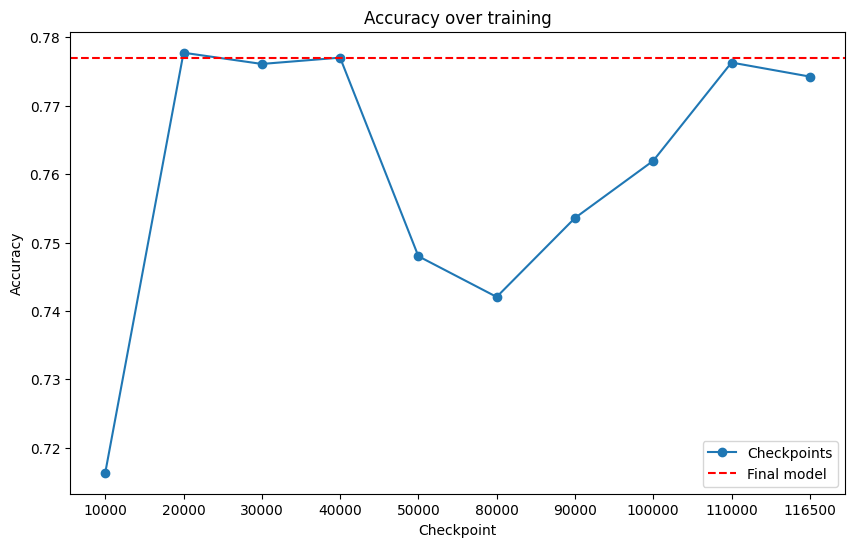

In [14]:
# sort checkpoints
checkpoints.sort(key=lambda x: int(x.split("-")[-1]))

# remove "checkpoint-" from checkpoint names
checkpoints = [checkpoint.split("-")[-1] for checkpoint in checkpoints]

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(checkpoints, [eval["eval_accuracy"] for eval in checkpoint_eval], marker='o', label="Checkpoints")
plt.axhline(y=final_model_eval["eval_accuracy"], color='r', linestyle='--', label="Final model")
plt.xlabel("Checkpoint")
plt.ylabel("Accuracy")
plt.title("Accuracy over training")
plt.xticks(range(len(checkpoints)), checkpoints)
plt.legend()
plt.show()


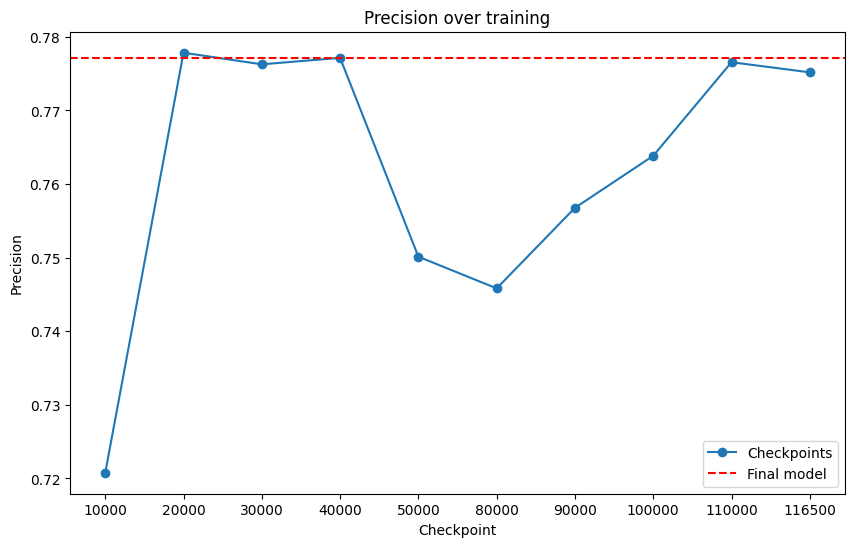

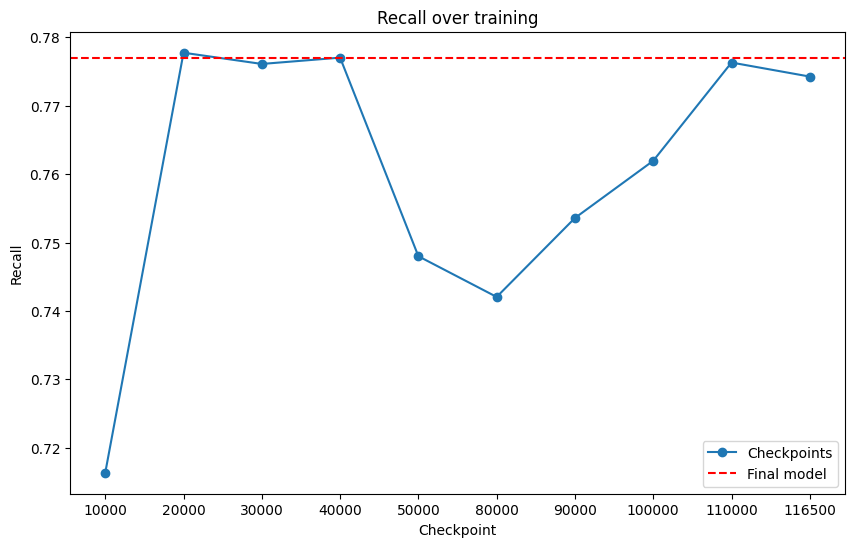

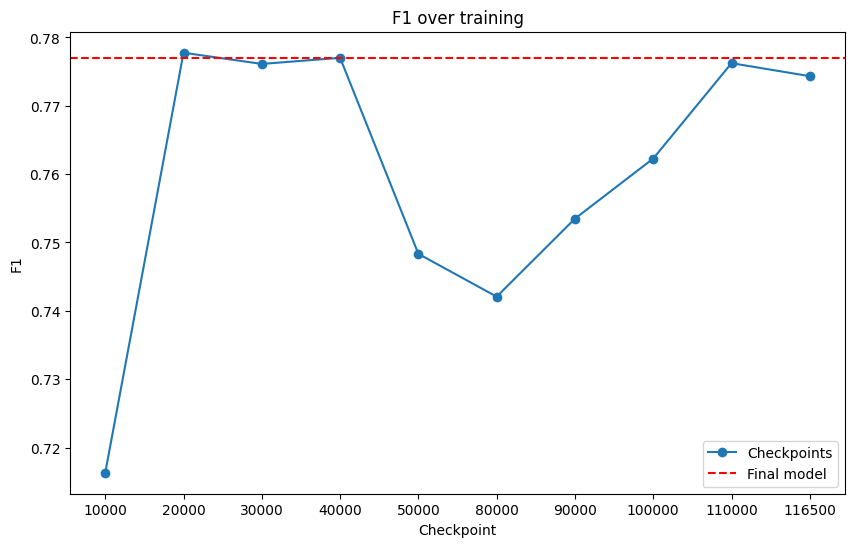

In [15]:
# make plots for other metrics
# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(checkpoints, [eval["eval_precision"] for eval in checkpoint_eval], marker='o', label="Checkpoints")
plt.axhline(y=final_model_eval["eval_precision"], color='r', linestyle='--', label="Final model")
plt.xlabel("Checkpoint")
plt.ylabel("Precision")
plt.title("Precision over training")
plt.xticks(range(len(checkpoints)), checkpoints)
plt.legend()
plt.show()

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(checkpoints, [eval["eval_recall"] for eval in checkpoint_eval], marker='o', label="Checkpoints")
plt.axhline(y=final_model_eval["eval_recall"], color='r', linestyle='--', label="Final model")
plt.xlabel("Checkpoint")
plt.ylabel("Recall")
plt.title("Recall over training")
plt.xticks(range(len(checkpoints)), checkpoints)
plt.legend()
plt.show()

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(checkpoints, [eval["eval_f1"] for eval in checkpoint_eval], marker='o', label="Checkpoints")
plt.axhline(y=final_model_eval["eval_f1"], color='r', linestyle='--', label="Final model")
plt.xlabel("Checkpoint")
plt.ylabel("F1")
plt.title("F1 over training")
plt.xticks(range(len(checkpoints)), checkpoints)
plt.legend()
plt.show()

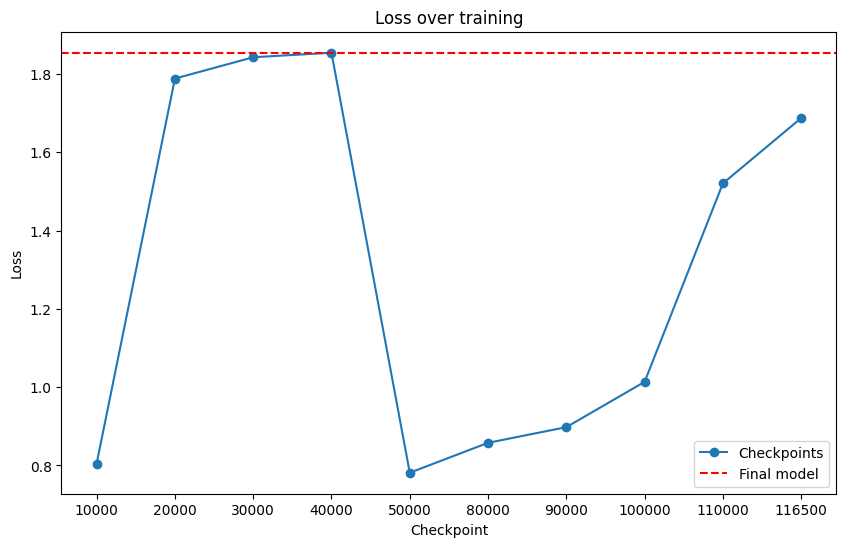

In [16]:
# also one for eval_loss
plt.figure(figsize=(10, 6))
plt.plot(checkpoints, [eval["eval_loss"] for eval in checkpoint_eval], marker='o', label="Checkpoints")
plt.axhline(y=final_model_eval["eval_loss"], color='r', linestyle='--', label="Final model")
plt.xlabel("Checkpoint")
plt.ylabel("Loss")
plt.title("Loss over training")
plt.xticks(range(len(checkpoints)), checkpoints)
plt.legend()
plt.show()

In [9]:
import torch
import torch.nn.functional as F

def get_predictions_and_confidence(model, data_loader, confidence_threshold=0.9):
    model = model.eval()  # Ensure the model is in evaluation mode
    predictions = []
    true_labels = []
    confidence_scores = []
    confident_predictions = []
    not_confident_predictions = []

    # Define the label to genre mapping
    label_to_genre = {
        0: "pop",
        1: "rap",
        2: "rock",
        3: "r&b",
        4: "latin",
        5: "edm"
    }

    with torch.no_grad():
        for batch in data_loader:
            if None in batch["sentence"]:
                continue  # Skip this batch if any sentence is None

            sentences = batch["sentence"]
            labels = batch["label"].to(device)

            # Tokenize the sentences and move inputs to the same device as the model
            inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
            inputs = {key: val.to(device) for key, val in inputs.items()}

            outputs = model(**inputs)
            logits = outputs.logits

            # Apply softmax to convert logits to probabilities
            probs = F.softmax(logits, dim=1)
            max_probs, preds = torch.max(probs, dim=1)

            # Store predictions, true labels, and confidence scores
            predictions.extend(preds.view(-1).tolist())
            true_labels.extend(labels.view(-1).tolist())
            confidence_scores.extend(max_probs.view(-1).tolist())

            # Process predictions to include genres and confidence
            for i, pred in enumerate(preds):
                genre = label_to_genre[pred.item()]
                true_genre = label_to_genre[labels[i].item()]  # Convert true label to genre
                confidence = max_probs[i].item()
                sentence = sentences[i]
                if confidence >= confidence_threshold:
                    confident_predictions.append((genre, true_genre, sentence, confidence))
                else:
                    not_confident_predictions.append((genre, true_genre, sentence, confidence))

    return {
        "true_labels": [label_to_genre[label] for label in true_labels],  # Convert true labels to genres
        "predictions": [label_to_genre[pred] for pred in predictions],  # Convert predictions to genres
        "confidence_scores": confidence_scores,
        "confident_predictions": confident_predictions,
        "not_confident_predictions": not_confident_predictions
    }


confidence_threshold = 0.9
results = get_predictions_and_confidence(model, test_loader, confidence_threshold)

confident_predictions = results["confident_predictions"]
not_confident_predictions = results["not_confident_predictions"]

# Print some examples of confident predictions
print("Confident Predictions:")
for pred, true_label, sentence, confidence in confident_predictions[:5]:  # Adjust the slice as needed
    print(f"Sentence: '{sentence}', Prediction: {pred}, True Label: {true_label}, Confidence: {confidence:.2f}")

print("\nNot Confident Predictions:")
for pred, true_label, sentence, confidence in not_confident_predictions[:5]:  # Adjust the slice as needed
    print(f"Sentence: '{sentence}', Prediction: {pred}, True Label: {true_label}, Confidence: {confidence:.2f}")
    

Confident Predictions:
Sentence: 'FINN. Good to meet you, Poe!', Prediction: edm, True Label: edm, Confidence: 1.00
Sentence: 'BILLY: At Gitmo, we had to water board Khalid Sheikh Mohammed 183 times over six months to get him to talk just once. Now, we ain't got six months. I doubt we've even got six hours.', Prediction: edm, True Label: edm, Confidence: 1.00
Sentence: 'Tony Stark: No. He was a uh... cellist, I think.', Prediction: r&b, True Label: r&b, Confidence: 1.00
Sentence: 'Now, Mrs. Jervis, comes poor Pamela's bundle; and a little one it is to the others. First, here is a calico nightgown, that I used to wear o' mornings. 'Twill be rather too good for me when I get home; but I must have something. Then there is a quilted calamanco coat, and a pair of stockings I bought of the pedlar, and my straw-hat with blue strings; and a remnant of Scots cloth, which will make two shirts and two shifts, the same I have on, for my poor father and mother. And here are four other shifts, one t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


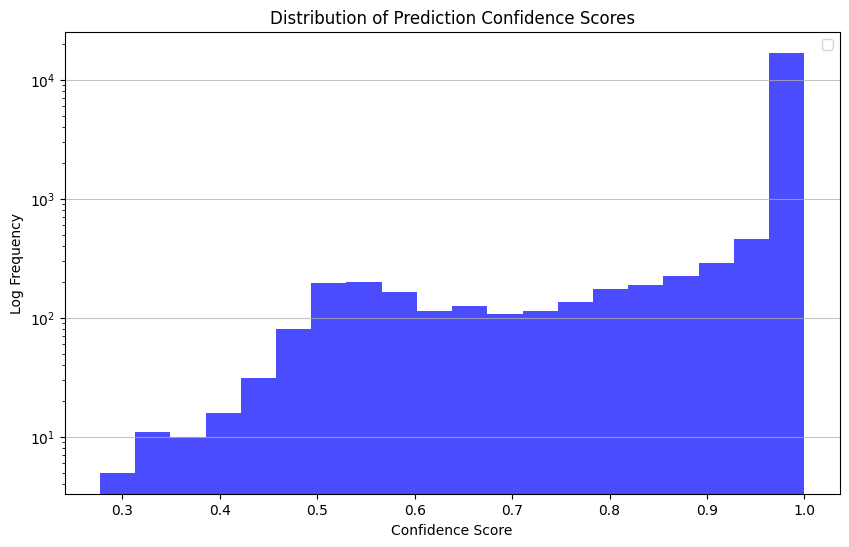

In [18]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def plot_confidence_distribution(confidence_scores):
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability
    plt.hist(confidence_scores, bins=20, alpha=0.7, color='blue', log=True)  # Enable logarithmic scale
    plt.title('Distribution of Prediction Confidence Scores')  # Set the title of the histogram
    plt.xlabel('Confidence Score')  # Label the x-axis as "Confidence Score"
    plt.ylabel('Log Frequency')  # Label the y-axis as "Log Frequency"
    plt.grid(axis='y', alpha=0.75)  # Add a grid for better readability
    plt.legend()  # Show the legend to explain the red line
    plt.show()  # Display the histogram

# Assuming you have already calculated the confidence scores using the updated function
confidence_scores = results["confidence_scores"]  # Use the confidence scores obtained from the function

# Plot the distribution of confidence scores
plot_confidence_distribution(confidence_scores)


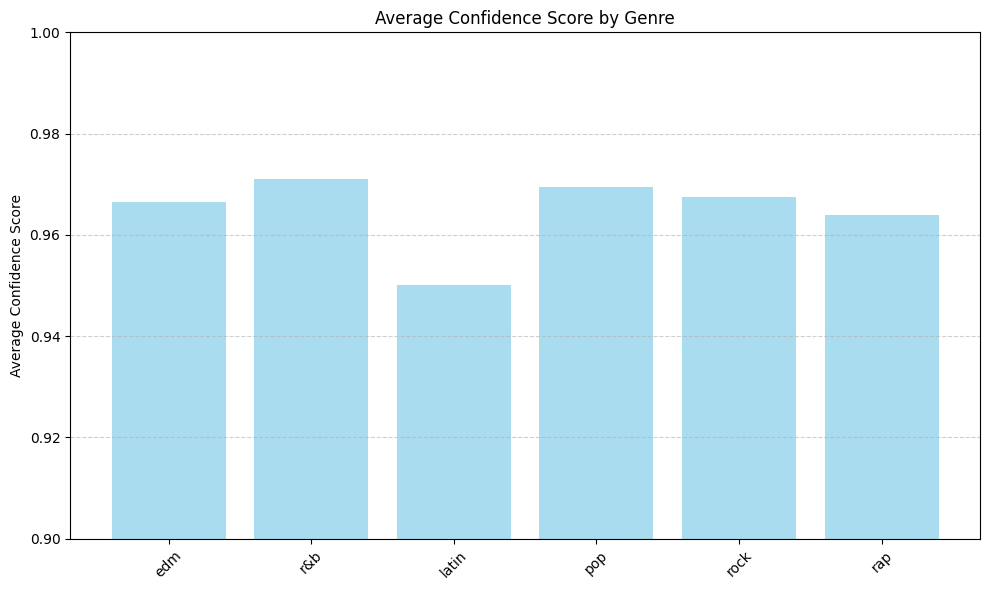

In [19]:
def plot_average_confidence_per_genre(confident_predictions, not_confident_predictions):
    # Combine confident and not confident predictions
    all_predictions = confident_predictions + not_confident_predictions
    
    # Initialize a dictionary to hold total confidence scores and counts per genre
    genre_confidence = {}

    # Aggregate confidence scores for each genre
    for genre, _, confidence in all_predictions:
        if genre not in genre_confidence:
            genre_confidence[genre] = {'total_confidence': 0, 'count': 0}
        genre_confidence[genre]['total_confidence'] += confidence
        genre_confidence[genre]['count'] += 1

    # Calculate average confidence score per genre
    average_confidence = {genre: values['total_confidence'] / values['count'] for genre, values in genre_confidence.items()}

    # Prepare data for plotting
    genres = list(average_confidence.keys())
    averages = [average_confidence[genre] for genre in genres]

    # Plotting
    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(genres))
    plt.bar(y_pos, averages, alpha=0.7, color='skyblue')
    plt.xticks(y_pos, genres, rotation=45)
    plt.ylabel('Average Confidence Score')
    plt.title('Average Confidence Score by Genre')

    # Set y-axis limits to only show values between 0.8 and 1.0
    plt.ylim(0.9, 1.0)

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()  # Adjust the layout to make room for the rotated x-axis labels
    plt.show()


# Assuming confident_predictions and not_confident_predictions are available from previous steps
plot_average_confidence_per_genre(confident_predictions, not_confident_predictions)
